In [ ]:
! pip install pandas==0.25

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%config InlineBackend.figure_format='retina'

%matplotlib inline

from pandas_profiling import ProfileReport

In [ ]:
PATH="drive/MyDrive/ORIE 5741/"

In [ ]:
# compas_scores=pd.read_csv(PATH+"compas-scores.csv")
# compas_scores_raw=pd.read_csv(PATH+"compas-scores-raw.csv")
compas_scores_two_years=pd.read_csv(PATH+"compas-scores-two-years.csv")
# compas_scores_two_years_violent=pd.read_csv(PATH+"compas-scores-two-years-violent.csv")

In [ ]:
compas_scores_two_years.r_charge_degree.fillna("NaN").apply(lambda x: x if x=="NaN" else x[1]).value_counts()

NaN    3743
M      2347
F      1122
C         2
Name: r_charge_degree, dtype: int64

In [ ]:
r_charge_degree_cat=compas_scores_two_years.r_charge_degree.fillna("NaN").apply(lambda x: x if x=="NaN" else x[1])
compas_scores_two_years_N=compas_scores_two_years[r_charge_degree_cat=="NaN"]
compas_scores_two_years_R=compas_scores_two_years[~(r_charge_degree_cat=="NaN")]

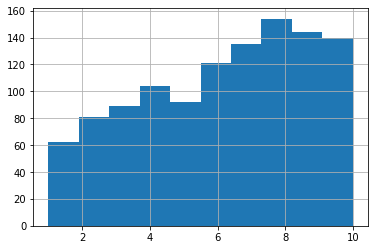

In [ ]:
compas_scores_two_years[r_charge_degree_cat=="F"].decile_score.hist()

In [ ]:
# split into two subsets
rec=compas_scores_two_years.query("is_recid==1")
rec.loc[:,"race"]=rec.loc[:,"race"].apply(lambda x: x if x not in ("Asian","Native American") else "Other")
nrec=compas_scores_two_years.query("is_recid==0")
nrec.loc[:,"race"]=nrec.loc[:,"race"].apply(lambda x: x if x not in ("Asian","Native American") else "Other")



/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [ ]:
def J(p,q):
    """
    probability ratio measure
    """
    return np.abs(p/q-1)

def p_Y_D(data,d,D):
    subset=data[data.loc[:,D]==d]
    probs=[]
    for level in ("Low","Medium","High"):
        nominator=subset.score_text==level
        probs.append(nominator.mean())
    return probs

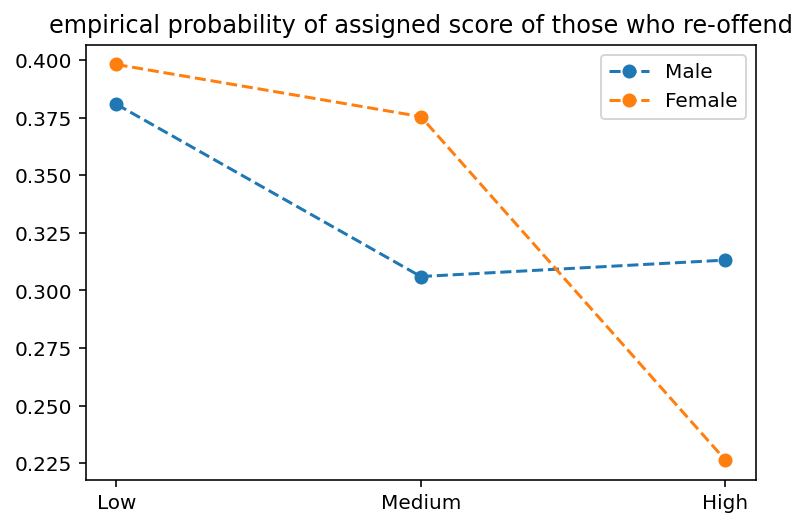

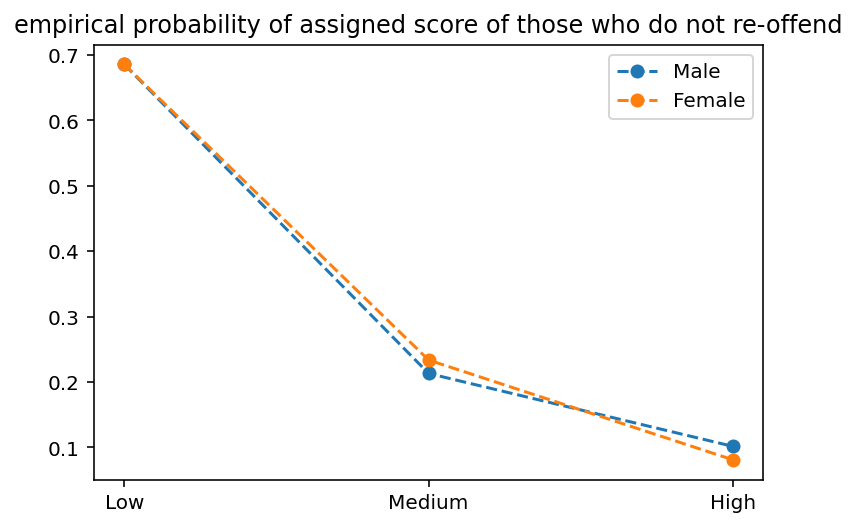

In [ ]:
for d in rec.sex.unique():
    plt.plot(("Low","Medium","High"),p_Y_D(rec,d,"sex"),'o--',label=d)
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()

for d in nrec.sex.unique():
    plt.plot(("Low","Medium","High"),p_Y_D(nrec,d,"sex"),'o--',label=d)
plt.legend()
plt.title("empirical probability of assigned score of those who do not re-offend")
plt.show()

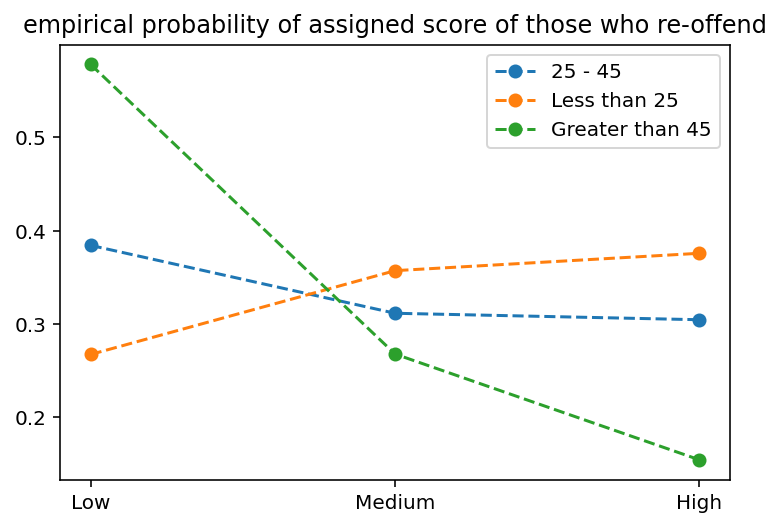

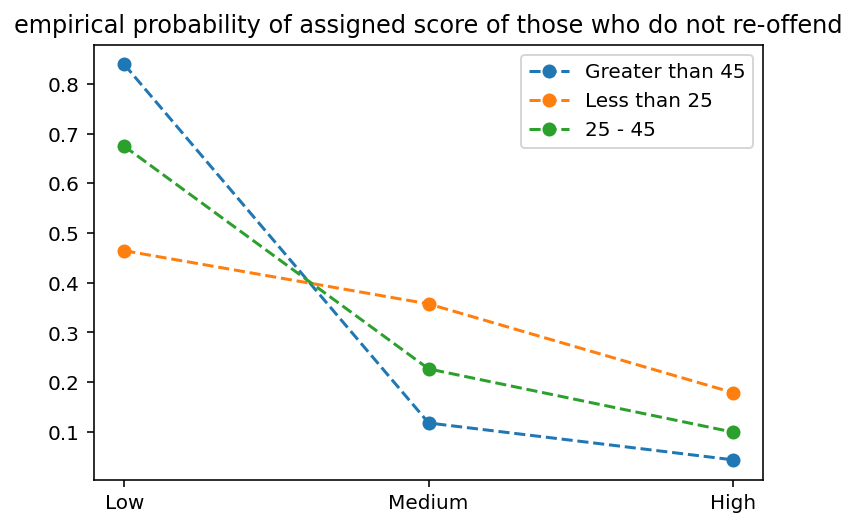

In [ ]:
for age in rec.age_cat.unique():
    plt.plot(("Low","Medium","High"),p_Y_D(rec,age,"age_cat"),'o--',label=age)
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()

for age in nrec.age_cat.unique():
    plt.plot(("Low","Medium","High"),p_Y_D(nrec,age,"age_cat"),'o--',label=age)
plt.legend()
plt.title("empirical probability of assigned score of those who do not re-offend")
plt.show()

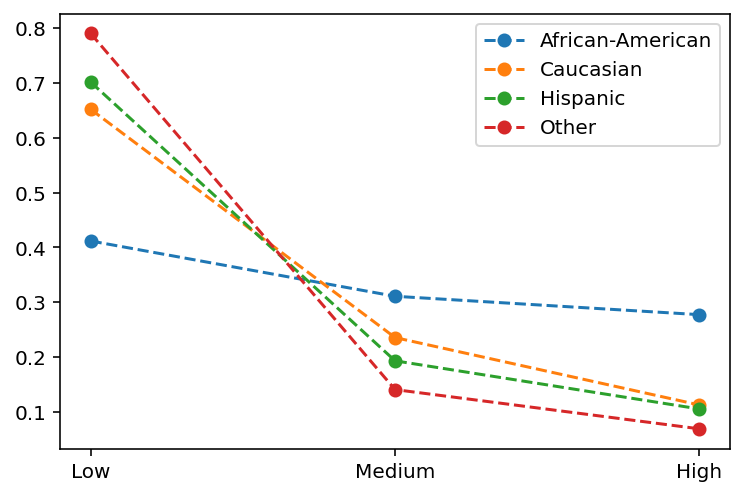

In [ ]:
for race in rec.race.unique():
    # print(race, p_Y_D(rec,race,"race"))
    plt.plot(("Low","Medium","High"),p_Y_D(compas_scores_two_years,race,"race"),'o--',label=race)
# plt.xticks=([0,1,2],("Low","Medium","High"))
plt.legend()
plt.show()

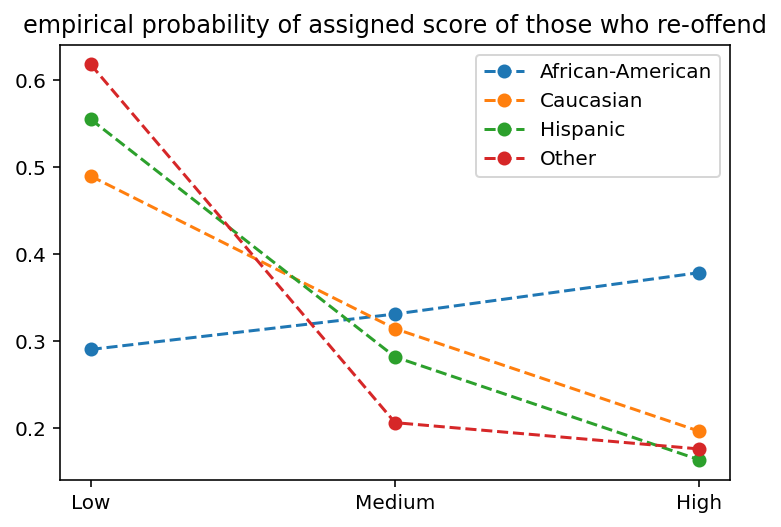

In [ ]:
for race in rec.race.unique():
    # print(race, p_Y_D(rec,race,"race"))
    plt.plot(("Low","Medium","High"),p_Y_D(rec,race,"race"),'o--',label=race)
# plt.xticks=([0,1,2],("Low","Medium","High"))
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()

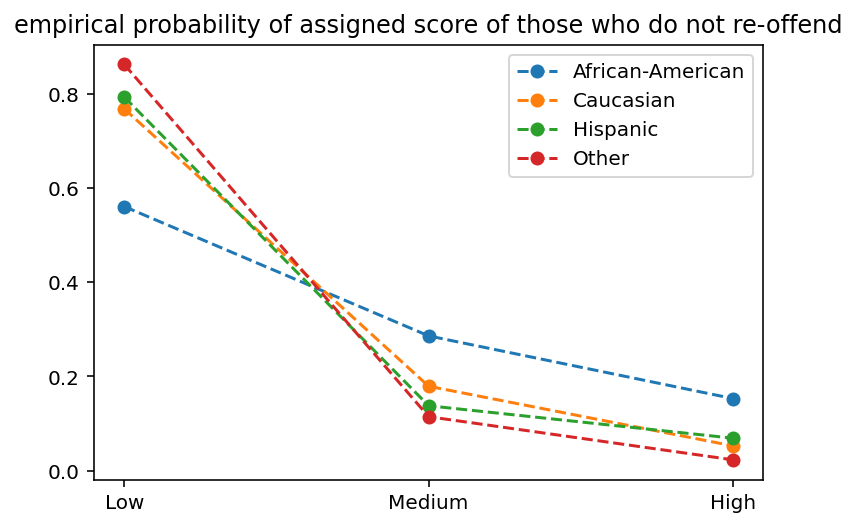

In [ ]:
for race in rec.race.unique():
    # print(race, p_Y_D(nrec,race,"race"))
    plt.plot(("Low","Medium","High"),p_Y_D(nrec,race,"race"),'o--',label=race)
plt.legend()
plt.title("empirical probability of assigned score of those who do not re-offend")
plt.show()

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
compas_scores_two_years.head(2)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,0,1,0,0,0,-1.0,2013-08-13 06:03:42,2013-08-14 05:41:20,13011352CF10A,2013-08-13,NaN,1.0,F,Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,2013-08-14,Risk of Violence,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,0,3,0,0,0,-1.0,2013-01-26 03:45:27,2013-02-05 05:36:53,13001275CF10A,2013-01-26,NaN,1.0,F,Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,2013-07-05,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),2013-07-05,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,2013-01-27,Risk of Violence,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1


In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
visible_features=[#"sex",
                  #"age",
                  "juv_fel_count",
                  "juv_misd_count",
                  "juv_other_count",
                  "priors_count",
                  "c_charge_degree"]
data=compas_scores_two_years.query("`r_charge_degree`!='(CO3)'")
X=data.loc[:,visible_features].copy()

charge_degree_encoder=OrdinalEncoder(categories=[["O","M","F"]])
X.loc[:,"c_charge_degree"]=charge_degree_encoder.fit_transform(X.loc[:,"c_charge_degree"].values.reshape(-1,1))
# X.loc[:,"sex"]=X.loc[:,"sex"].apply(lambda x: 1 if x=="Male" else 0)

y=data.two_year_recid

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
model=LogisticRegression(penalty="l1",solver="liblinear")
model.fit(X_train,y_train)

LogisticRegression(penalty='l1', solver='liblinear')

In [ ]:
# fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test,model.predict_proba(X_test)[:,1])
fpr_lr, tpr_lr, _ = metrics.roc_curve(y_test,model.decision_function(X_test))
roc_auc_lr = metrics.auc(fpr_lr, tpr_lr)

In [ ]:
from sklearn import metrics

In [ ]:
Y=compas_scores_two_years.loc[:,["decile_score","two_year_recid"]]
y_true=Y.iloc[:,1]
y_pred=Y.iloc[:,0]/10

In [ ]:
fpr, tpr, _ = metrics.roc_curve(y_true,y_pred)
roc_auc = metrics.auc(fpr, tpr)

In [ ]:
%matplotlib inline

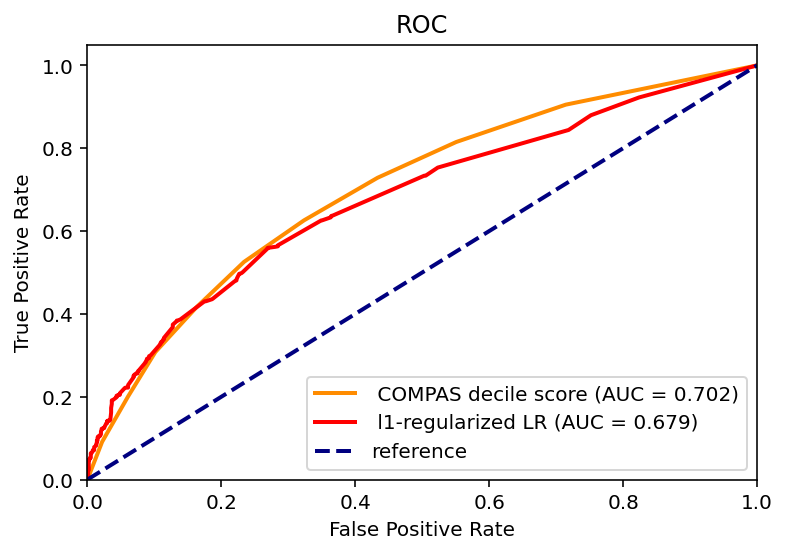

In [ ]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label=" COMPAS decile score (AUC = %0.3f)" % roc_auc,
)
plt.plot(
    fpr_lr,
    tpr_lr,
    color="red",
    lw=lw,
    label=" l1-regularized LR (AUC = %0.3f)" % roc_auc_lr,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="reference")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

In [ ]:
LR_cat=[]
for i in model.predict_proba(X_test)[:,1]:
    if 0<=i<0.4:
        LR_cat.append("Low")
    elif 0.4<=i<0.8:
        LR_cat.append("Medium")
    else:
        LR_cat.append("High")

In [ ]:
rec_test=compas_scores_two_years.loc[X_test.index].copy()
rec_test.loc[:,"LR_cat"]=LR_cat
rec_test=rec_test.query("`is_recid`==1").copy()

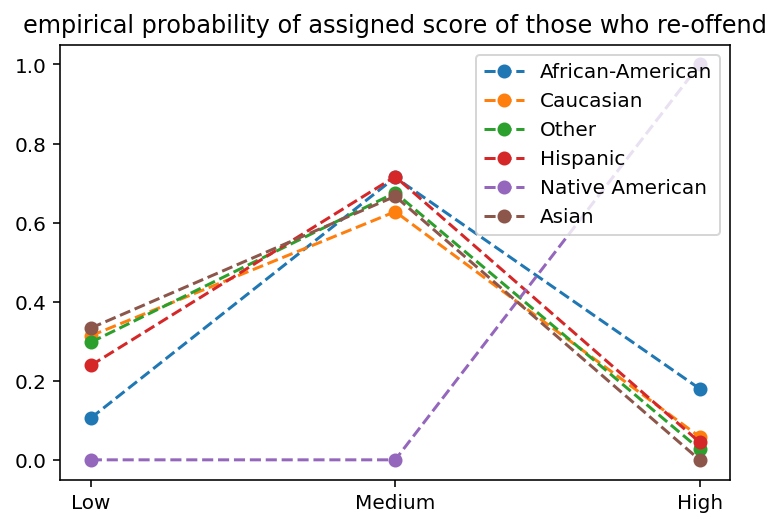

In [ ]:
def p_Y_D(data,d,D):
    subset=data[data.loc[:,D]==d]
    probs=[]
    for level in ("Low","Medium","High"):
        nominator=subset.LR_cat==level
        probs.append(nominator.mean())
    return probs

    
for race in rec_test.race.unique():
    # print(race, p_Y_D(rec,race,"race"))
    plt.plot(("Low","Medium","High"),p_Y_D(rec_test,race,"race"),'o--',label=race)
# plt.xticks=([0,1,2],("Low","Medium","High"))
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()

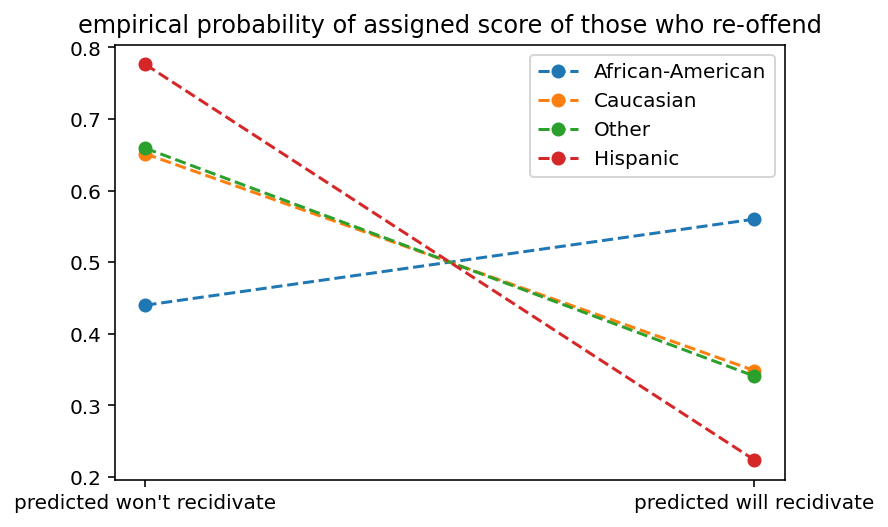

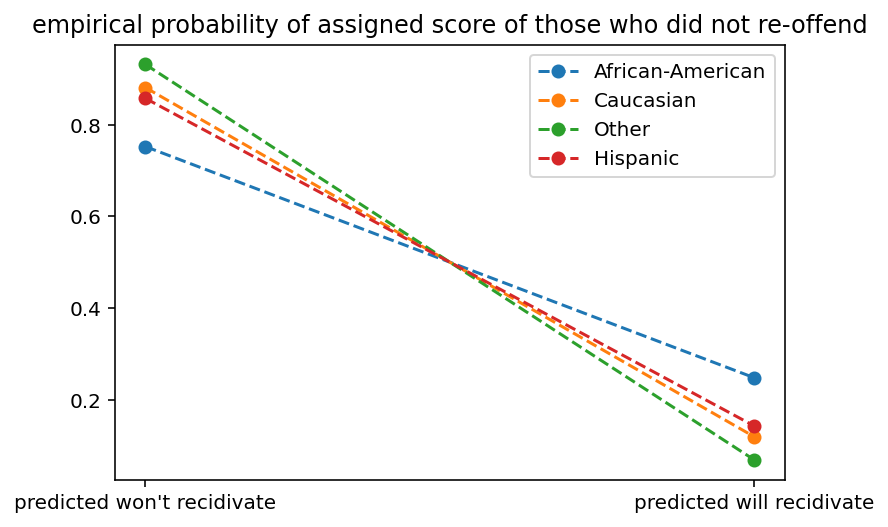

In [ ]:
def p_Y_D(data,d,D):
    subset=data[data.loc[:,D]==d]
    probs=[]
    for level in range(2):
        nominator=subset.LR_pred==level
        probs.append(nominator.mean())
    return probs

rec_test=compas_scores_two_years.loc[X_test.index].copy()
rec_test.loc[:,"LR_pred"]=model.predict(X_test)
rec_test.loc[:,"race"]=rec_test.loc[:,"race"].apply(lambda x: x if x not in ("Asian","Native American") else "Other")

for race in rec_test.race.unique():
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==1"),race,"race"),'o--',label=race)
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()
    
for race in rec_test.race.unique():
    # print(race, p_Y_D(rec,race,"race"))
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==0"),race,"race"),'o--',label=race)
# plt.xticks=([0,1,2],("Low","Medium","High"))
plt.legend()
plt.title("empirical probability of assigned score of those who did not re-offend")
plt.show()

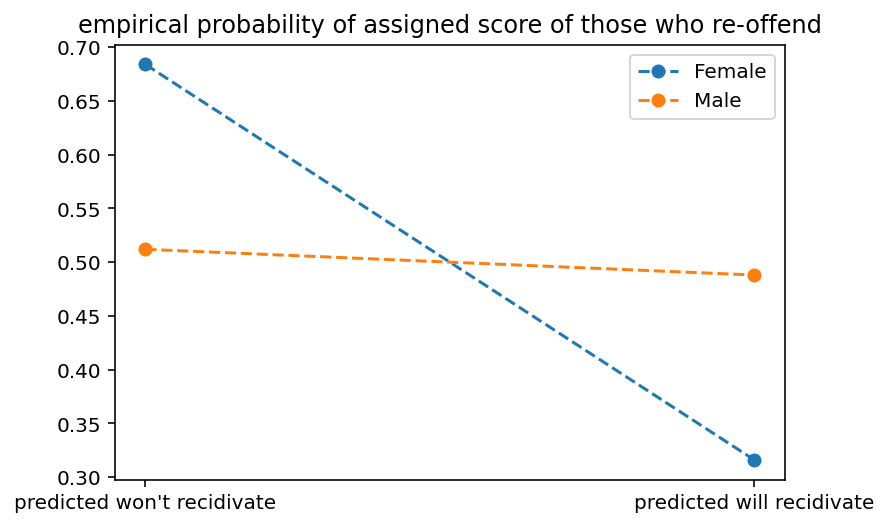

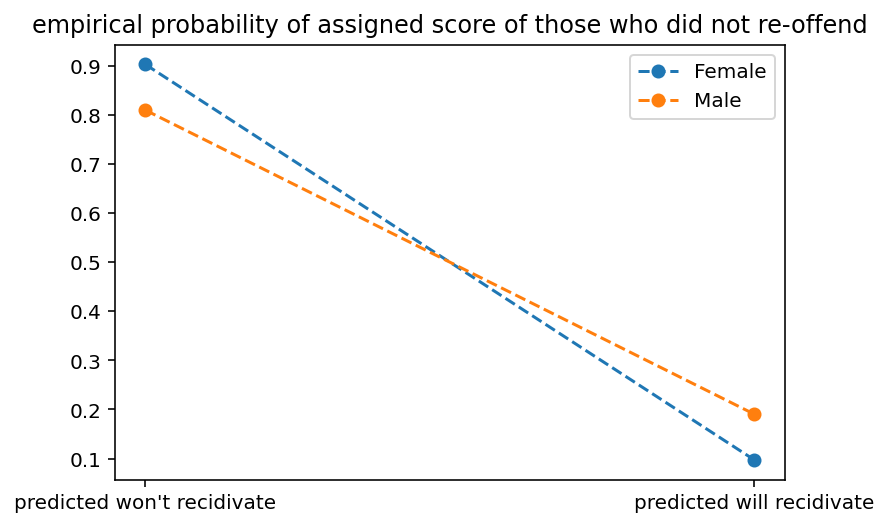

In [ ]:
for g in rec_test.sex.unique():
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==1"),g,"sex"),'o--',label=g)
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()
    
for g in rec_test.sex.unique():
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==0"),g,"sex"),'o--',label=g)
plt.legend()
plt.title("empirical probability of assigned score of those who did not re-offend")
plt.show()

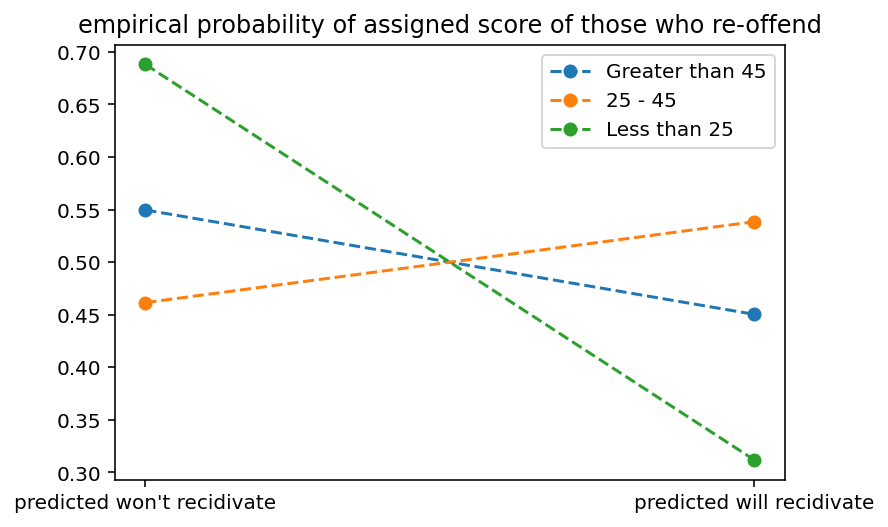

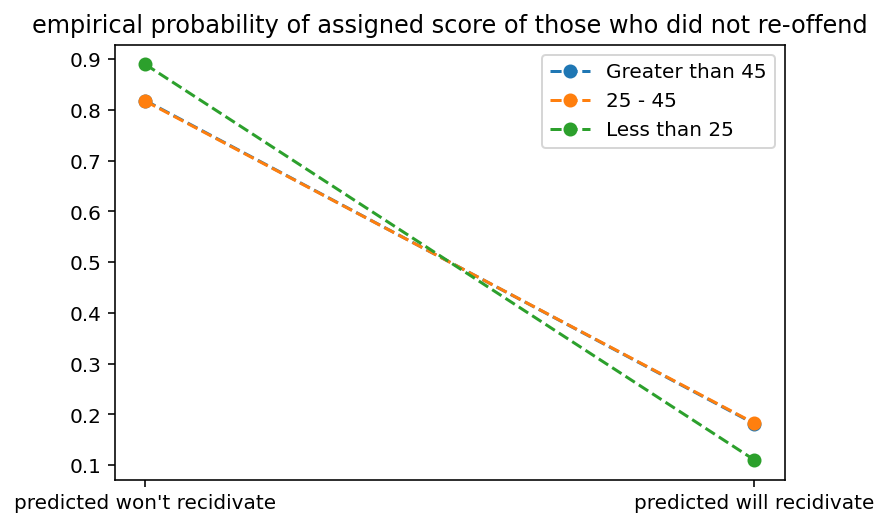

In [ ]:
for g in rec_test.age_cat.unique():
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==1"),g,"age_cat"),'o--',label=g)
plt.legend()
plt.title("empirical probability of assigned score of those who re-offend")
plt.show()
    
for g in rec_test.age_cat.unique():
    plt.plot(["predicted won't recidivate","predicted will recidivate"],p_Y_D(rec_test.query("`is_recid`==0"),g,"age_cat"),'o--',label=g)
plt.legend()
plt.title("empirical probability of assigned score of those who did not re-offend")
plt.show()

<hr>

In [ ]:

# empirical distribution of assigned certain risk score given race
reoffend_emp={}
innocent_emp={}

for race in rec.race.unique():
    reoffend_emp[race]=p_Y_D(rec,race,"race")

for race in nrec.race.unique():
    innocent_emp[race]=p_Y_D(nrec,race,"race")

In [ ]:
from itertools import combinations

In [ ]:
R_emp_dist={}
for d1,d2 in combinations(reoffend_emp.keys(),2):
    # discrimination=J(reoffend_emp[d1][0],reoffend_emp[d2][0])
    R_emp_dist[(d1,d2)]=J(reoffend_emp[d1][2],reoffend_emp[d2][2])
    R_emp_dist[(d2,d1)]=J(reoffend_emp[d2][2],reoffend_emp[d1][2])



In [ ]:
R_emp_dist

{('African-American', 'Caucasian'): 0.4073069216258737,
 ('African-American', 'Hispanic'): 0.4770780365191263,
 ('African-American', 'Other'): 0.5304374205477869,
 ('Caucasian', 'African-American'): 0.6872138995501629,
 ('Caucasian', 'Hispanic'): 0.11771879483500713,
 ('Caucasian', 'Other'): 0.2077474892395983,
 ('Hispanic', 'African-American'): 0.9123312269070063,
 ('Hispanic', 'Caucasian'): 0.1334254817464835,
 ('Hispanic', 'Other'): 0.10204081632653061,
 ('Other', 'African-American'): 1.1296415936009843,
 ('Other', 'Caucasian'): 0.26222383194494747,
 ('Other', 'Hispanic'): 0.11363636363636354}

In [ ]:
pd.Series(R_emp_dist).to_frame().unstack().fillna(0)

0                              
                 African-American Caucasian  Hispanic     Other
African-American         0.000000  0.407307  0.477078  0.530437
Caucasian                0.687214  0.000000  0.117719  0.207747
Hispanic                 0.912331  0.133425  0.000000  0.102041
Other                    1.129642  0.262224  0.113636  0.000000

In [ ]:
rec.race.value_counts()

African-American    2036
Caucasian           1025
Hispanic             245
Other                165
Name: race, dtype: int64

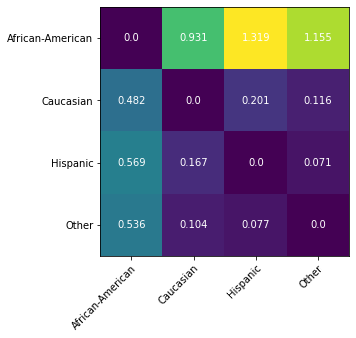

In [ ]:
df=pd.Series(R_emp_dist).to_frame().unstack().fillna(0)
fig, ax = plt.subplots(figsize=(5,5))
im = ax.imshow(df)

# We want to show all ticks...
ax.set_xticks(np.arange(len(df)))
ax.set_yticks(np.arange(len(df)))
# ... and label them with the respective list entries
ax.set_xticklabels(df.index)
ax.set_yticklabels(df.index)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(df)):
    for j in range(len(df)):
        text = ax.text(j, i, round(df.iloc[i, j],3),
                       ha="center", va="center", color="w")

fig.tight_layout()
plt.show()


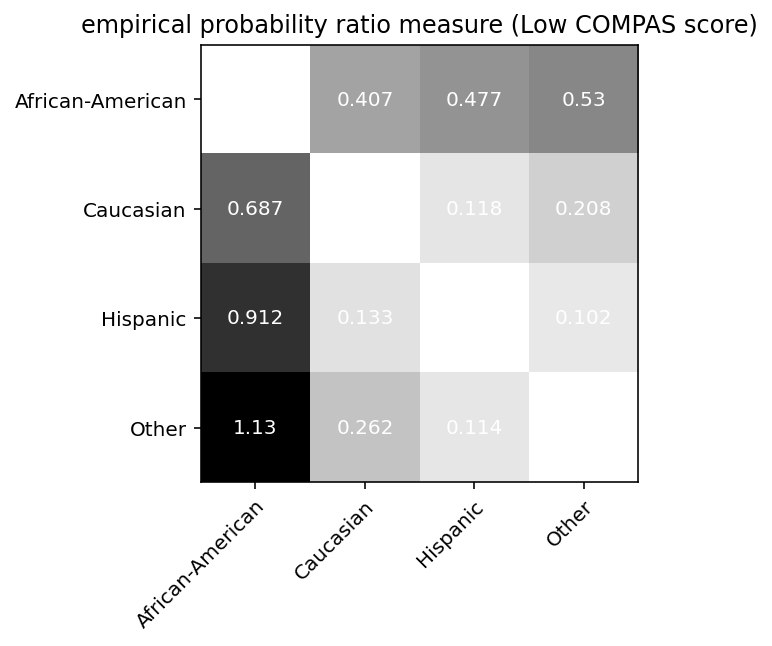

1.1296415936009843


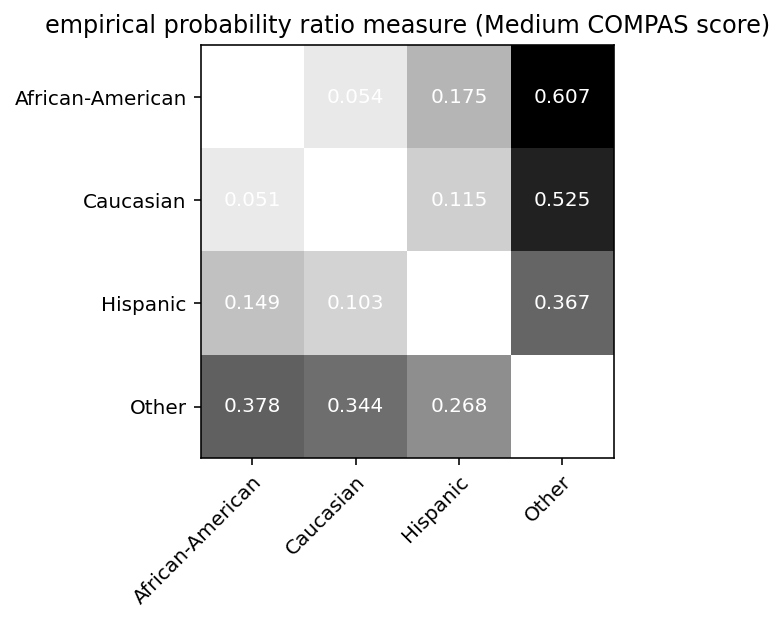

0.60652374898879


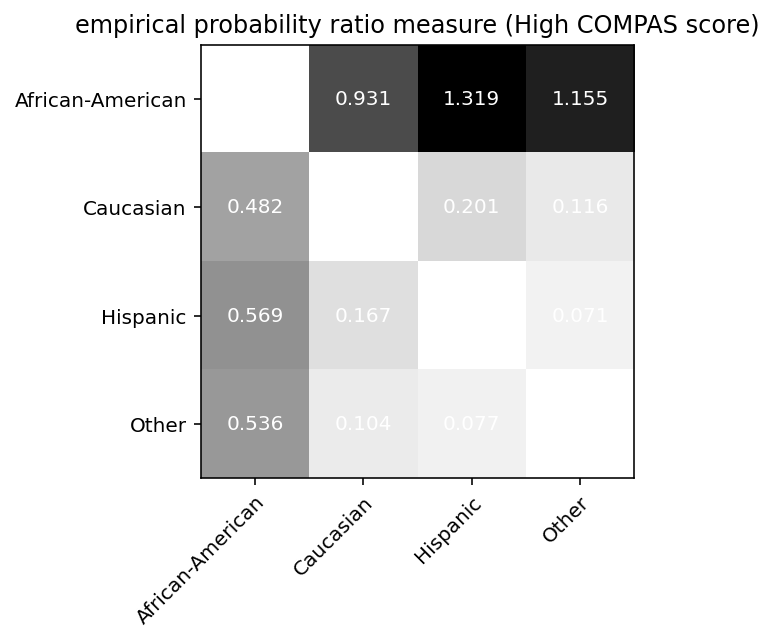

1.319437622789784


In [ ]:
for i, title in enumerate(["Low","Medium","High"]):
    R_emp_dist={}
    for d1,d2 in combinations(reoffend_emp.keys(),2):
        R_emp_dist[(d1,d2)]=J(reoffend_emp[d1][i],reoffend_emp[d2][i])
        R_emp_dist[(d2,d1)]=J(reoffend_emp[d2][i],reoffend_emp[d1][i])

    df=pd.Series(R_emp_dist).to_frame().unstack().fillna(0)
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(df,cmap="binary")

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(df)))
    ax.set_yticks(np.arange(len(df)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(df.index)
    ax.set_yticklabels(df.index)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(df)):
        for j in range(len(df)):
            text = ax.text(j, i, round(df.iloc[i, j],3),
                        ha="center", va="center", color="w")

    ax.set_title(f"empirical probability ratio measure ({title} COMPAS score)")
    fig.tight_layout()
    plt.show()
    print(df.values.max())


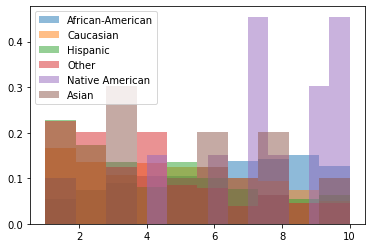

In [ ]:
for race in compas_scores_two_years_R.race.unique():
    plt.hist(compas_scores_two_years_R.query("race==@race").decile_score,density=True,alpha=0.5,label=race)
plt.legend()
plt.show()

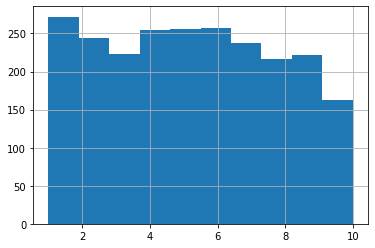

In [ ]:
compas_scores_two_years[r_charge_degree_cat=="M"].decile_score.hist()

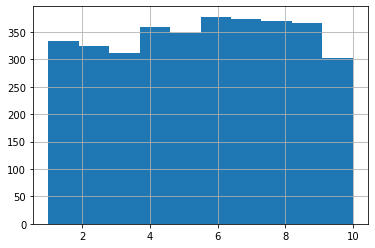

In [ ]:
compas_scores_two_years_R.decile_score.hist()

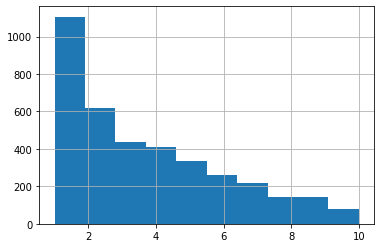

In [ ]:
compas_scores_two_years_N.decile_score.hist()

In [ ]:
profile=ProfileReport(compas_scores)
profile.to_file("compas_scores_profile.html")

/usr/local/lib/python3.7/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [ ]:
%matplotlib inline  

In [ ]:
compas_scores_two_years.loc[:,["age","decile_score"]].corr()

,age,decile_score
age,1.000000,-0.387733
decile_score,-0.387733,1.000000


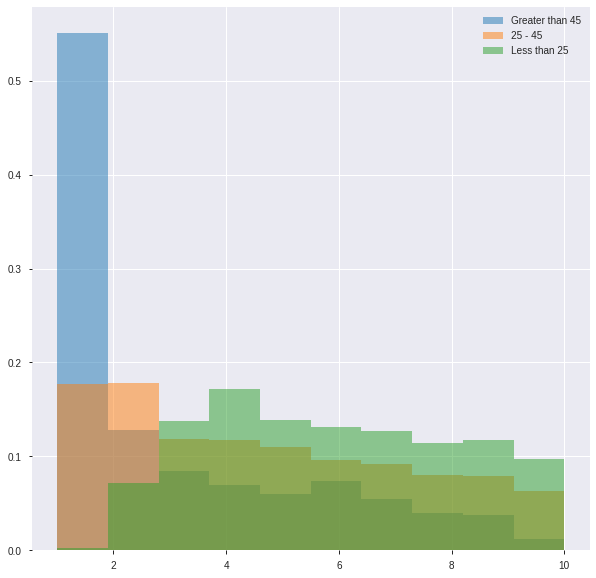

In [ ]:
plt.figure(figsize=(10,10))
for i in compas_scores_two_years.age_cat.unique():
    tmp=compas_scores_two_years.query("age_cat==@i")
    plt.hist(tmp.decile_score,alpha=0.5,label=i,density=True)

plt.legend()
plt.show()


In [ ]:
compas_scores_two_years.pivot_table(index="score_text",columns="r_charge_degree",values="is_violent_recid",aggfunc="count").fillna(0)

r_charge_degree,(CO3),(F1),(F2),(F3),(F5),(F6),(F7),(M1),(M2),(MO3)
score_text,,,,,,,,,,
High,1.0,25.0,79.0,330.0,0.0,2.0,2.0,338.0,250.0,14.0
Low,1.0,16.0,48.0,267.0,1.0,1.0,3.0,472.0,508.0,14.0
Medium,0.0,10.0,41.0,295.0,0.0,0.0,2.0,391.0,349.0,11.0


In [ ]:
compas_scores_two_years.query("age_cat=='Less than 25'")

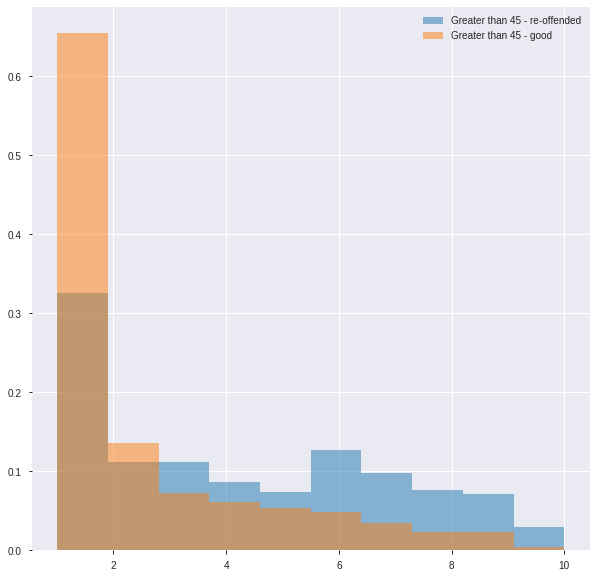

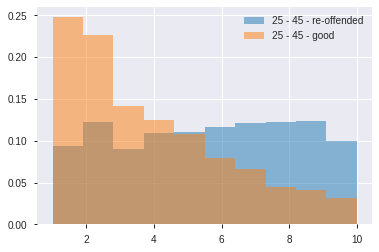

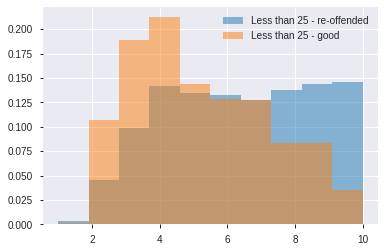

In [ ]:
plt.figure(figsize=(10,10))
for i in compas_scores_two_years.age_cat.unique():
    tmp=compas_scores_two_years.query("age_cat==@i")
    plt.hist(tmp.query("two_year_recid==1").decile_score,alpha=0.5,label=f"{i} - re-offended",density=True)
    plt.hist(tmp.query("two_year_recid==0").decile_score,alpha=0.5,label=f"{i} - good",density=True,stacked=True)
    plt.legend()
    plt.show()

# plt.legend()
# plt.show()
